## Project Overview

Churn is a problem that companies face on a regular basis. Customers may drop a service for a variety of reasons. They may find competitors better. They may find cost prohibitive. They may simply forget to renew a subscription. Whatever the reason may be, customer churn is an undesirable aspect of doing business and companies like to avoid it. 


In this project, a fictional music app called Sparkify is set up with user data. The aim in this project is to use customer data to create a predictive model of customer churn in the Spark big-data framework. If companies are able to utilize customer-usage data and find patterns in them and map them accurately to indicate which customers might churn, they could, in principle, incentivize customers to stay with them. Finding such patterns could also be useful from the perspective of targeted advertising - customers demographics with advantageous average behavior can be targeted for advertising with hopes of better returns than blanket advertising.

## Problem Statement, Solution Strategy and Expected Result

Using Spark and associated libraries and customer data for Sparkify, a fictitious music app, create and validate a predictive model for customer churn. The strategy for solving this problem is broadly speaking as follows - Churn is defined as an existing customer cancelling a subscription. Having defined churn, differences in customer demographic (location, gender) and usage (time spent, engagement) between groups of customers that churn versus those that don't churn are explored. The <i>a priori</i> expectation is that some of these features will reveal a substantial difference between customers that churn versus those that don't. This information is used to create useful features for a classification model for churn. A simple model with a minimum number of features that can easily be interpreted is first attempted and is optimized for performance. If the need arises, more complicated features involving usage statistics on a per-customer level will be designed and used for machine learning.

## Metrics

 The classification model is evaluated using standard metrics for binary output data - accuracy and F1-score. F1-score is given greater importance from an interpretation perspective due to imbalanced nature of the output data (significantly fewer customers churn than don't).

In [1]:
# Import required libraries
import time
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, IntegerType, FloatType, DoubleType, Row, DateType, StringType
from pyspark.ml.linalg import SparseVector, DenseVector

from pyspark.sql.functions import when, col, desc, min, max, sum, split, udf, count, \
                                  rand, isnan, isnull, from_unixtime, datediff,\
                                  to_date, lit, current_date

from pyspark.ml.feature import Bucketizer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

# First create a Spark session
spark = SparkSession \
    .builder \
    .appName("Predict Churn for Sparkify") \
    .getOrCreate()

df_sparkify = spark.read.json('mini_sparkify_event_data.json')

# Data Exploration
As of the first attempt, data exploration is done chiefly using pandas, not Spark. The reason for this is the speed vs. scalability tradeoff for this dataset. The exploratory dataset is small enough to be efficiently explored in pandas. All further code involving data-munging, transformation, feature creation and machine learning are done within Spark.

In [2]:
# Check columns and types
df_sparkify.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [3]:
# Print out the first five rows to get a snapshot into the data
df_sparkify.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [4]:
pdf = df_sparkify.toPandas() # pdf  = alias for pandas dataframe

In [5]:
# Check size of data
pdf.shape

(286500, 18)

In [6]:
# Check for the presence of Null values
pdf.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

Artist, length and song null values seem to be correlated. First name, Gender, Last Name, Location and Registration and user Agent seem to also be correlated in terms of having null values. Let's explore the correlation a bit more.

In [7]:
pdf[pdf['artist'].isnull()].head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
11,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
14,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
35,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
44,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
47,None,Logged In,Micah,M,95,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Down,1.538332e+12,8,None,307,1538355306000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
51,None,Logged In,Micah,M,97,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Home,1.538332e+12,8,None,200,1538355504000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
53,None,Logged In,Micah,M,99,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Logout,1.538332e+12,8,None,307,1538355687000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
56,None,Logged In,Ashlynn,F,9,Williams,NaN,free,"Tallahassee, FL",PUT,Thumbs Up,1.537365e+12,217,None,307,1538355711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",74
57,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,


In [8]:
pdf[pdf['firstName'].isnull()].head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
57,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
58,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
59,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
60,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
76,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,
77,None,Logged Out,None,None,3,None,NaN,free,None,PUT,Login,NaN,240,None,307,1538356679000,None,
110,None,Logged Out,None,None,0,None,NaN,free,None,PUT,Login,NaN,100,None,307,1538358102000,None,
146,None,Logged Out,None,None,0,None,NaN,free,None,PUT,Login,NaN,241,None,307,1538360117000,None,
183,None,Logged Out,None,None,14,None,NaN,free,None,GET,Home,NaN,187,None,200,1538361527000,None,
184,None,Logged Out,None,None,15,None,NaN,free,None,PUT,Login,NaN,187,None,307,1538361528000,None,


It appears that empty userID columns are of logged out users. Does the correlation hold the other way? Let's find out.

In [9]:
pdf[pdf['userId']==''][['auth','userId']].groupby('auth').count()

,userId
auth,
Guest,97
Logged Out,8249


Since we're interested in predictive analysis of churn in registered users (with assigned userIDs), we can safely filter out Guest and Logged Out users. As mentioned previously, data-wrangling can be done in Spark.

In [10]:
df_sparkify = df_sparkify.where(col('userId') != '')

To verify that the filtering has indeed taken place, compare the previous version of the auth column with the new one.

In [11]:
pdf['auth'].value_counts()

Logged In     278102
Logged Out      8249
Guest             97
Cancelled         52
Name: auth, dtype: int64

In [12]:
df_sparkify.groupBy('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [13]:
# Keep pdf up-to-date after filtering
pdf = df_sparkify.toPandas()

Let's explore the 'page' column and find out a little more about it.

In [14]:
pdf['page'].value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancellation Confirmation        52
Cancel                           52
Name: page, dtype: int64

This does not necessarily obtain cancellation data at user level. So it might be useful to find how many distinct users cancelled. To do this, first compute the number of distinct users.

In [15]:
len(pdf['userId'].value_counts().index)

225

So there are 225 distinct users in the new dataset. Next, compute the number of cancellation-type events.

In [16]:
len(pdf[(pdf['page']=='Cancel') | (pdf['page']=='Cancellation Confirmation')].index.unique())

104

It is unclear if the 'Cancellation Confirmation' and 'Cancel' belong to distinct users.

In [17]:
pdf[(pdf['page']=='Cancel') | (pdf['page']=='Cancellation Confirmation')][['userId','page']].head(10)

,userId,page
19586,18,Cancel
19592,18,Cancellation Confirmation
23070,32,Cancel
23072,32,Cancellation Confirmation
36648,125,Cancel
36649,125,Cancellation Confirmation
39107,105,Cancel
39109,105,Cancellation Confirmation
40724,17,Cancel
40728,17,Cancellation Confirmation


It's clear that the same users that 'Cancel' also confirm their cancellation. So there are essentially 52 users who cancel. The users that elect to downgrade don't seem to cancel. 

In [18]:
pdf[(pdf['page']=='Cancel') & (pdf['page']=='Downgrade')][['userId','page']].head(10)

,userId,page


Since the events are mutually exclusive, we could target these users as well. It might help correct for the asymmetry in numbers between users that cancel and users that don't.

In [19]:
len(pdf[(pdf['page']=='Downgrade')]['userId'].unique())

154

Since a large number of users seem to have downgraded, this would shift the asymmetry in numbers in the other direction. So, for a start it is perhaps best to avoid users that downgrade.

### Churn definition

The challenge here is to define churn at a user level in Spark. In Pandas this is quite easy to do, but in Spark this can get a little messy. One way to achieve this in Spark is to first filter out all userIds corresponding to Cancel Confirmation events. Save this as a separate dataset. Create a column named churn with value 1 for this dataset. Then filter out the complement of all those userIds. Create a column named churn with value zero for this dataset. Save as a separate dataset. Then, merge the two datasets. <i><b>Churn is therefore defined at a user level in this dataset as the subset of users for which there is a single   'Cancellation Confirmation' event</i></b>. The next step is to merge this churn dataset with the original dataset to ensure that all rows corresponding to churned userIds have the 'churn' column = 1 in the original dataset.

In [20]:
# First create a SQL view to enable standard SQL syntax
df_sparkify.createOrReplaceTempView('sparkify_users')

# Subset of users who cancelled
churned_users = spark.sql('SELECT DISTINCT userId, 1 as churn FROM sparkify_users WHERE Page = "Cancellation Confirmation"')

# Subset of users who didn't cancel
no_churn_users = spark.sql('SELECT DISTINCT userId, 0 as churn FROM sparkify_users WHERE userId NOT IN \
                           (SELECT DISTINCT userId FROM sparkify_users WHERE Page = "Cancellation Confirmation")')

# Merge the datasets
user_churn_df = churned_users.union(no_churn_users)

# Create an SQL view
user_churn_df.createOrReplaceTempView('sparkify_user_churn')

# Then randomize the dataset
user_churn_df = spark.sql('SELECT * FROM sparkify_user_churn ORDER BY RAND()')

# Update the SQL view
user_churn_df.createOrReplaceTempView('sparkify_user_churn')

# Merge original dataset with the new dataset
df_sparkify = df_sparkify.join(user_churn_df, on='userId')

In [21]:
pdf = df_sparkify.toPandas()
pdf.head(5)

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,churn
0,100010,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
1,100010,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
2,100010,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
3,100010,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
4,100010,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0


## Data Visualization

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


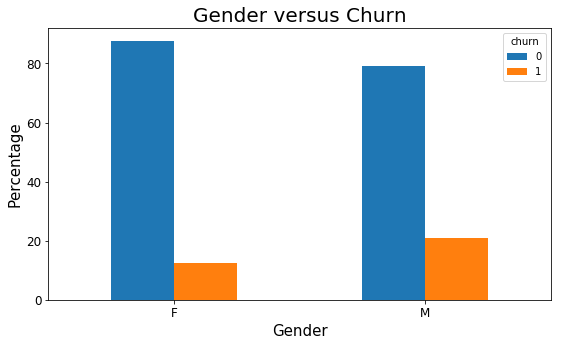

In [26]:
# Gender versus churn
gender_cross = pd.crosstab(pdf['gender'],pdf['churn']).apply(lambda x: 100*x/x.sum(), axis=1)
gender_cross.plot.bar(figsize=(9,5))
plt.xlabel('Gender',fontsize=15)
plt.ylabel('Percentage',fontsize=15)
plt.title('Gender versus Churn',fontsize=20)
plt.setp(plt.axes().get_xticklabels(), rotation='horizontal', fontsize=12)
plt.setp(plt.axes().get_yticklabels(), rotation='horizontal', fontsize=12)
plt.show()
plt.savefig('gender_churn.png')

A greater proportion (~8% more) of men churn versus women. It is unclear as of this first attempt if this is statistically significant, but seems like a useful feature to keep.

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


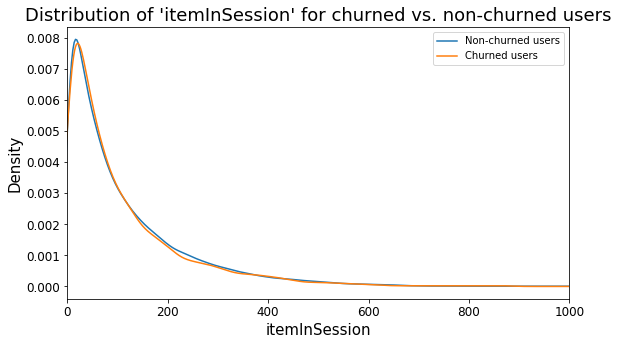

In [27]:
plt.figure(figsize=(9,5))
pdf[pdf['churn']==0]['itemInSession'].plot.kde(label='Non-churned users')
pdf[pdf['churn']==1]['itemInSession'].plot.kde(label='Churned users')
plt.title('Distribution of \'itemInSession\' for churned vs. non-churned users',fontsize=18)
plt.xlim(0,1000)
plt.xlabel('itemInSession',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.setp(plt.axes().get_xticklabels(), rotation='horizontal', fontsize=12)
plt.setp(plt.axes().get_yticklabels(), rotation='horizontal', fontsize=12)
plt.legend()
plt.savefig('itemInSession_churn.png')

No clear distinction exists between the distribution of itemInSession for churned and non-churned users. so this feature does not seem like the most informative feature to use for machine learning.

In [25]:
pdf['length'].describe()

count    228108.000000
mean        249.117182
std          99.235179
min           0.783220
25%         199.888530
50%         234.500770
75%         277.158730
max        3024.665670
Name: length, dtype: float64

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


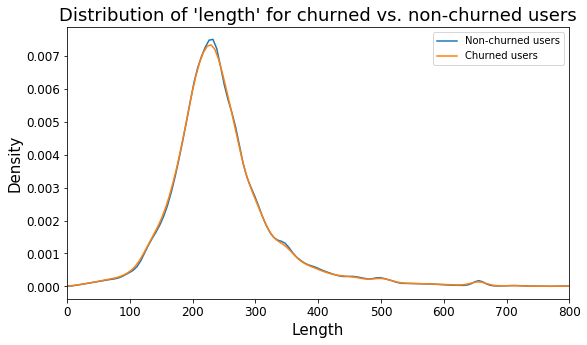

In [28]:
plt.figure(figsize=(9,5))
pdf[pdf['churn']==0]['length'].plot.kde(label='Non-churned users')
pdf[pdf['churn']==1]['length'].plot.kde(label='Churned users')
plt.title('Distribution of \'length\' for churned vs. non-churned users',fontsize=18)
plt.xlim(0,800)
plt.xlabel('Length',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.setp(plt.axes().get_xticklabels(), rotation='horizontal', fontsize=12)
plt.setp(plt.axes().get_yticklabels(), rotation='horizontal', fontsize=12)
plt.legend()
plt.savefig('length_churn.png')

In [27]:
pdf['level'].value_counts()

paid    222433
free     55721
Name: level, dtype: int64

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


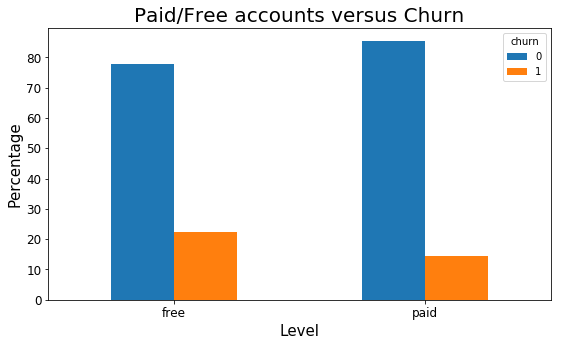

In [30]:
# Percentage of paid/free accounts that churn
level_cross = pd.crosstab(pdf['level'],pdf['churn']).apply(lambda x: 100*x/x.sum(), axis=1)
level_cross.plot.bar(figsize=(9,5))
plt.xlabel('Level',fontsize=15)
plt.ylabel('Percentage',fontsize=15)
plt.title('Paid/Free accounts versus Churn',fontsize=20)
plt.setp(plt.axes().get_xticklabels(), rotation='horizontal', fontsize=12)
plt.setp(plt.axes().get_yticklabels(), rotation='horizontal', fontsize=12)
plt.show()
plt.savefig('level_churn.png')

A greater proportion (~8% more) of free-account users churn versus paid account users. Again, as of a first attempt it is unclear if this is statistically significant, but like gender, it seems like a useful feature to keep.

In [30]:
pd.crosstab(pdf['location'],pdf['churn'])

churn,0,1
location,,
"Albany, OR",0,23
"Albany-Schenectady-Troy, NY",0,457
"Alexandria, LA",955,0
"Allentown-Bethlehem-Easton, PA-NJ",815,0
"Anchorage, AK",1496,0
"Atlanta-Sandy Springs-Roswell, GA",4236,0
"Atlantic City-Hammonton, NJ",2176,0
"Austin-Round Rock, TX",1682,0
"Bakersfield, CA",1775,0


Location information seems to be useful in creating features - there seem to be some locations that have a significant propotion of churning users. since there are 114 distinct locations in the dataset, it's probably a better idea to categorize location information into high-probability of churn-versus low/medium probability of churn buckets.

In [31]:
# Percentage of paid/free accounts that churn
pd.crosstab(pdf['method'],pdf['churn']).apply(lambda x: 100*x/x.sum(), axis=1)

churn,0,1
method,,
GET,81.623721,18.376279
PUT,84.048049,15.951951


Since there is no data dictionary provided, the meaning of these columns is not known. So while I suspect that PUT/GET refer to actions taken by the system while fetching or updating information regarding users, I still need to see if it has power in predicting churn. It seems like it doesn't.

Another useful feature to use maybe the time elapsed between the creation of the account (registration) and the last recorded activity timestamp. The intution here is that greater the time delta, greater the probability that the user will stay on the platform.

In [33]:
userid_max_ts = pdf[['userId','ts']].groupby('userId').max()
userid_max_ts_dict = userid_max_ts['ts'].to_dict()

In [34]:
pdf['timeSpentSeconds'] = (pdf['userId'].apply(lambda x:userid_max_ts_dict[x]) - pdf['registration'])/1000
pdf['timeSpentNorm'] = pdf['timeSpentSeconds']/pdf['timeSpentSeconds'].max()

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


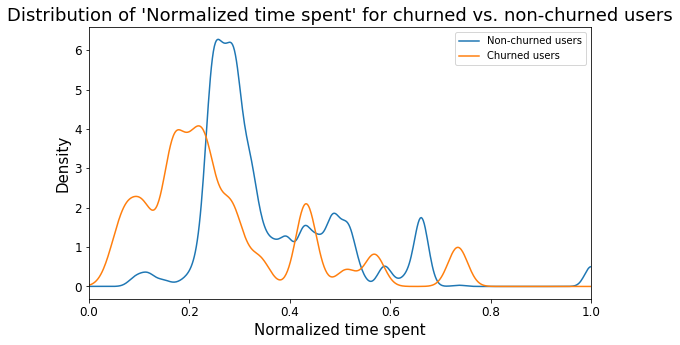

In [36]:
plt.figure(figsize=(9,5))
pdf[pdf['churn']==0]['timeSpentNorm'].plot.kde(label='Non-churned users')
pdf[pdf['churn']==1]['timeSpentNorm'].plot.kde(label='Churned users')
plt.title('Distribution of \'Normalized time spent\' for churned vs. non-churned users',fontsize=18)
plt.xlabel('Normalized time spent',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.xlim(0,1)
plt.setp(plt.axes().get_xticklabels(), rotation='horizontal', fontsize=12)
plt.setp(plt.axes().get_yticklabels(), rotation='horizontal', fontsize=12)
plt.legend()
plt.savefig('timespent_churn.png')

There is a clear difference between distributions on this feature, with churned users frequently spending lesser time on the platform than non-churned users. While it may not give an exact prediction, since some churned users also have a significant amount of time spent on the platform, it seems like a useful feature to include in modeling, especially because Non-churned users peak quite a bit above churned users both in terms of density and normalized time spent.

Next, I define user engagement as the total number of interactions a user has on the application. While it isn't necessary that more engaged users won't churn, the hope is that the analysis shows some distinctions between user usage patterns for churned v. non-churned users.

In [38]:
user_engagement_dict = pdf.groupby('userId').count()['page'].to_dict()
pdf['user_engagement'] = pdf['userId'].apply(lambda x: user_engagement_dict[x])

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


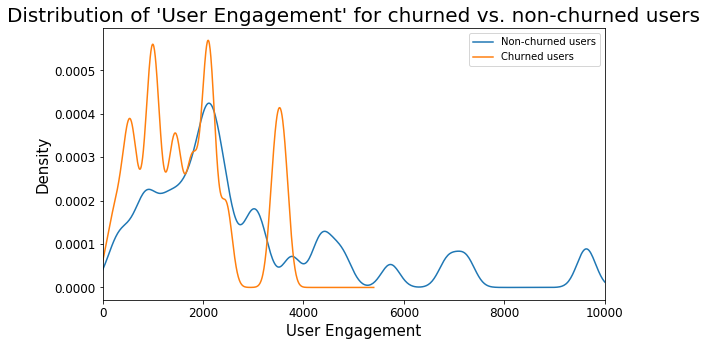

In [39]:
plt.figure(figsize=(9,5))
pdf[pdf['churn']==0]['user_engagement'].plot.kde(label='Non-churned users')
pdf[pdf['churn']==1]['user_engagement'].plot.kde(label='Churned users')
plt.title('Distribution of \'User Engagement\' for churned vs. non-churned users',fontsize=20)
plt.xlabel('User Engagement',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.setp(plt.axes().get_xticklabels(), rotation='horizontal', fontsize=12)
plt.setp(plt.axes().get_yticklabels(), rotation='horizontal', fontsize=12)
plt.xlim(0,10000)
plt.legend()
plt.savefig('user_engage_churn.png')

There seems to be a significant difference between the two distributions. It is clear that all users who churn don't interact too long with the platform. The maximum engagement for churned users is 4000 events and the distribution is rather narrow.
For non-churned users the engagement is broader, and the distribution has larger and longer tails.

# Feature Engineering/Data Preprocessing

Broadly speaking, the section above identified a few promising features based on exploration of correlations and differences between the two categories. 'gender', 'level', 'location', 'timespentNormalized', 'userEngagement' were identified as potentially useful features for machine learning. The next step is to perform feature engineering in Spark to createfeatures useful for machine learning.

In [40]:
# Create two new columns corresponding to event dates and registration dates
df_sparkify = df_sparkify.withColumn('event_date', from_unixtime((col('ts')/1000)).cast(DateType()))
df_sparkify = df_sparkify.withColumn('reg_date', from_unixtime((col('registration')/1000)).cast(DateType()))

In [41]:
# Create a column containing the maximum timestamp for a given user and merge with original
query = "SELECT userId, max(ts) as maxts \
         FROM sparkify_users \
         GROUP BY userId"
df_temp  = spark.sql(query)
df_sparkify = df_sparkify.join(df_temp,on='userId')
df_sparkify.show(n=5)

+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+-----+----------+----------+-------------+
|userId|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|churn|event_date|  reg_date|        maxts|
+------+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+-----+----------+----------+-------------+
|100010|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla

In [42]:
# Create a column that calculates days between maximum timestamp and registration date
df_sparkify = df_sparkify.withColumn('timeSpentMax',\
                                     datediff(end=from_unixtime(col('maxts')/1000).cast(DateType()),\
                                              start = col('reg_date'))\
                                    )

In [43]:
# Create a column containing total number of interactions a user has had with a platform
query = "SELECT userId, count(*) as user_engagement \
         FROM sparkify_users \
         GROUP BY userId"
df_temp  = spark.sql(query)
df_sparkify = df_sparkify.join(df_temp,on='userId')

In [44]:
# Update the SQL view
df_sparkify.createOrReplaceTempView('sparkify_users')

In [45]:
# Create a column containing the count of churn=1 for a given location and then compute the proportion churned

# First create a dataset grouped by location counting the number of churn instances
query = "SELECT location, COUNT(*) as loc_total_churn \
         FROM sparkify_users \
         WHERE churn=1 \
         GROUP BY location \
         ORDER by location"
df_temp1  = spark.sql(query)

# Then create a dataset grouped by location counting the total number of users at each location
query = "SELECT location, count(*) as loc_total \
         FROM sparkify_users \
         GROUP BY location \
         ORDER BY location"
df_temp2  = spark.sql(query)

# finally do a left join - the locations for which there was no churn will be marked as nulls
df_temp = df_temp2.join(df_temp1,on='location',how='left')

# Convert the nulls to zero
df_temp = df_temp.na.fill(0)

# Sort and show
df_temp = df_temp.withColumn('pchurn',col('loc_total_churn')/col('loc_total'))

In [46]:
# bin the pchurn column into distinct categories based on whether p churn is <.3, .3<pchurn<.6 or pchurn>0.6

bucketizer = Bucketizer(splits=[ 0, 0.3, 0.6, 1.0 ],inputCol="pchurn", outputCol="buckets")
df_temp = bucketizer.setHandleInvalid("keep").transform(df_temp)

# Convert bucket column to categorical column "location_churn"
churn_labels = {0.0:"Low Churn Location", 1.0: "Medium Churn Location", 2.0:"High Churn Location"}
udf_churn_loc = udf(lambda x: churn_labels[x], StringType())
df_temp = df_temp.withColumn("location_churn", udf_churn_loc("buckets"))

In [47]:
# Now merge this dataset with the main dataset. Drop other columns. Only keep 'location churn'
columns_to_drop = ['loc_total', 'loc_total_churn','pchurn','buckets']
df_temp = df_temp.drop(*columns_to_drop)

In [48]:
df_sparkify = df_sparkify.join(df_temp,on='location')

In [49]:
# The product of time spent and user engagement. The hope in using this feature 
# is to enhance the difference between the two churn groups.

df_sparkify = df_sparkify.withColumn('time_engage_prod',col('timeSpentMax')*col('user_engagement'))
pdf = df_sparkify.toPandas()

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


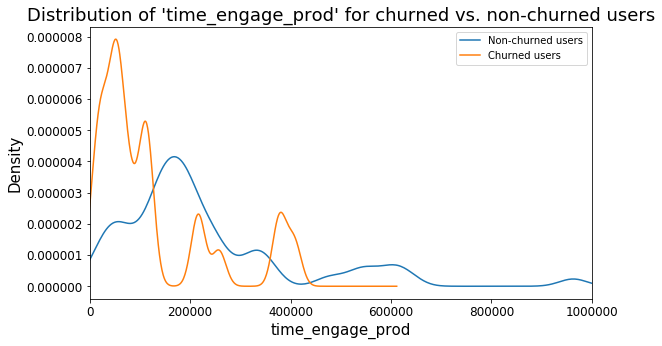

In [50]:
plt.figure(figsize=(9,5))
pdf[pdf['churn']==0]['time_engage_prod'].plot.kde(label='Non-churned users')
pdf[pdf['churn']==1]['time_engage_prod'].plot.kde(label='Churned users')
plt.title('Distribution of \'time_engage_prod\' for churned vs. non-churned users',fontsize=18)
plt.xlabel('time_engage_prod',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.setp(plt.axes().get_xticklabels(), rotation='horizontal', fontsize=12)
plt.setp(plt.axes().get_yticklabels(), rotation='horizontal', fontsize=12)
plt.xlim(0,1e6)
plt.legend()
plt.savefig('eng_time_prod_churn.png')


In principle, normalized higher order products of the above two features may be able to resolve the two groups apart even further, but for the time being, I'm going to stick with the simple first order product.

In [77]:
# Drop all other columns other than relevant columns identified as potential features columns
# I'm deciding to use 'gender', 'level', 'timeSpentMax', 'user_engagement', 'location_churn',
# 'time_engage_prod' as my initial set of features.

columns_to_keep = ['gender','level','location_churn','timeSpentMax','user_engagement','time_engage_prod','churn']

columns_to_drop = [col for col in df_sparkify.columns if col not in columns_to_keep]

df_features = df_sparkify.drop(*columns_to_drop)
df_features.printSchema()

root
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- timeSpentMax: integer (nullable = true)
 |-- user_engagement: long (nullable = false)
 |-- location_churn: string (nullable = true)
 |-- time_engage_prod: long (nullable = true)



In [78]:
# Check for the presence of null values - remove any if necessary
df_features.select([count(when(isnan(c), c)).alias(c) for c in df_features.columns]).show()

+------+-----+-----+------------+---------------+--------------+----------------+
|gender|level|churn|timeSpentMax|user_engagement|location_churn|time_engage_prod|
+------+-----+-----+------------+---------------+--------------+----------------+
|     0|    0|    0|           0|              0|             0|               0|
+------+-----+-----+------------+---------------+--------------+----------------+



In [79]:
# Select required columns, add a 'label' column required by Spark
df_features = df_features.select(col('gender').alias('gender'),
                                 col('level').alias('level'),
                                 col('timeSpentMax').alias('timeSpentMax'),
                                 col('user_engagement').alias('user_engagement'),
                                 col('location_churn').alias('location_churn'),
                                 col('time_engage_prod').alias('time_engage_prod'),
                                 col('churn').alias('label'))

This completes the feature engineerinng/data-processing step. As of this first attempt, I am choosing to NOT normalize any of my numeric columns. If I find problems in algorithm convergence, especially in Gradient Boosted Classification, I will consider normalizing the numeric columns.

# Modeling

In [80]:
# Convert categorical variables to index variables, create a pipeline for machine learning
gender_index = StringIndexer(inputCol='gender', outputCol='gend_idx')
level_index = StringIndexer(inputCol='level', outputCol='level_idx')
loc_churn_index = StringIndexer(inputCol='location_churn', outputCol='loc_churn_idx')
all_features = VectorAssembler(inputCols=['gend_idx',
                                          'level_idx',
                                          'loc_churn_idx',
                                          'timeSpentMax',
                                          'user_engagement',
                                          'timeSpentMax'],
                           outputCol='features')
features_pipeline = Pipeline(stages=[gender_index, level_index, loc_churn_index, all_features])

# Fit the pipeline
df_model = features_pipeline.fit(df_features).transform(df_features)

In [52]:
df_model

DataFrame[gender: string, level: string, timeSpentMax: int, user_engagement: bigint, location_churn: string, time_engage_prod: bigint, label: int, gend_idx: double, level_idx: double, loc_churn_idx: double, features: vector]

A custom function for training and evaluating multiple classification models is created. The tradeoff of speed of execution versus accuracy is used to select the best model for optimization

In [81]:
# Custom function to train and evaluate default model

def train_evaluate_default_model(train_data, test_data, model_type="logistic"):
    '''
    Fit and evaluate models on training and test data respectively. 
    
    Arguments:
    train_data: Spark DataFrame
        Training data
    test_data: Spark DataFrame
        Testing data
    model_type: string
        One of 'logistic','random forest','gradient boosting'.
    
    Outputs:
    model: Spark Classifier
        The classification model fit on the data

    '''
    # Create a dictionary with keys as model_type and values as respective default models
    model_dict={'logistic': LogisticRegression(),
                'random forest': RandomForestClassifier(),
                'gradient boosting':GBTClassifier()
               }
    
    # Instantiate model
    model = model_dict[model_type]
    
    start_time = time.time()
    # train model
    model_fit = model.fit(train_data)
    predictions = model_fit.transform(test_data)
    
    # Evaluation metrics - accuracy, F1-score
    acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = acc_eval.evaluate(predictions.select(col('label'), col('prediction')))
    
    f1_eval = MulticlassClassificationEvaluator(metricName='f1')
    f1 = f1_eval.evaluate(predictions.select(col('label'), col('prediction')))
    end_time = time.time()
    print('Model: {}, Test Accuracy: {:.4%}, Test F-1 score: {:.4%}, time required for fitting and evaluation: {} seconds'\
    .format(model, accuracy, f1,end_time-start_time))
    
    return model_fit

In [82]:
# It is unclear to me if all the algorithms being implemented can use Sparse data types. 
# So I am going to Convert sparse vector data to dense to be on the safe side 

df_sparse = df_model.select("label", "features")
rdd = df_sparse.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray())))
ml_data = spark.createDataFrame(rdd)

# Create training and evaluation (test) data
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=1234)

In [64]:
# Loop through model types and evaluate
model_type_list = ['logistic', 'random forest', 'gradient boosting']

for model_type in model_type_list:
    train_evaluate_default_model(model_type=model_type,test_data=test_data,train_data=train_data)

Model: LogisticRegression_6d534475608e, Test Accuracy: 91.1599%, Test F-1 score: 90.3750%, time required for fitting and evaluation: 204.3302345275879
Model: RandomForestClassifier_b5823d6c1e21, Test Accuracy: 96.8853%, Test F-1 score: 96.8899%, time required for fitting and evaluation: 285.6659400463104
Model: GBTClassifier_fa6f74f79515, Test Accuracy: 99.2123%, Test F-1 score: 99.2094%, time required for fitting and evaluation: 587.6399395465851


In [72]:
# Get default values of key parameters for RF model as a reference

test = RandomForestClassifier()
print(test.getOrDefault('minInfoGain'))
print(test.getOrDefault('numTrees'))
print(test.getOrDefault('maxDepth'))

0.0
20
5


In [ ]:
# Tweaking the Model - model optimization through grid search and cross validation
# Equivalent of GridSearchCV in sklearn

model_to_optimize = RandomForestClassifier()
param_grid = ParamGridBuilder().addGrid(model_to_optimize.minInfoGain, [0, 0.5])\
                               .addGrid(model_to_optimize.maxDepth, [3, 5]) \
                               .addGrid(model_to_optimize.numTrees, [20, 30]).build()

cv_obj = CrossValidator(estimator = Pipeline(stages=[model_to_optimize]),
                        evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                        estimatorParamMaps = param_grid,
                        numFolds = 3)

classification = cv_obj.fit(train_data)
predictions = classification.transform(test_data)

acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

In [93]:
accuracy = acc_eval.evaluate(predictions.select(col('label'), col('prediction')))
f1 = f1_eval.evaluate(predictions.select(col('label'), col('prediction')))

print('Model to optimize - {}:'.format(model_to_optimize))
print('Accuracy - {}:'.format(accuracy))
print('F1 score - {}:'.format(f1))

Model to optimize - RandomForestClassifier_0f82c6b4f062:
Accuracy - 0.9744715447154472:
F1 score - 0.9741106655335288:


In [95]:
print('Optimized Params - minInfoGain: {}'.format(classification.bestModel.stages[-1]._java_obj.getMinInfoGain()))
print('Optimized Params - maxDepth: {}'.format(classification.bestModel.stages[-1]._java_obj.getMaxDepth()))
print('Optimized Params - numTrees: {}'.format(classification.bestModel.stages[-1]._java_obj.getNumTrees()))

Optimized Params - minInfoGain: 0.0
Optimized Params - maxDepth: 5
Optimized Params - numTrees: 30


In [98]:
# Feature importances
classification.bestModel.stages[-1].featureImportances

SparseVector(6, {0: 0.0117, 1: 0.0033, 2: 0.615, 3: 0.094, 4: 0.0909, 5: 0.1851})

Examining feature importances and correlating the indices to feature vectors (0-gender, 1-level, 2-location_churn, 3-timeSpentMax, 4-user_engagement, 5-time_engage_prod) it is very clear that most of the variance in the data can be explained by the location_churn variable. I suspect that one reason such high accuracy and F1-scores were obtained was because there was some data-leakage in the definition of the location_churn variable. location_churn assigns low, medium and high probability of churn to locations for which churn is already known. Model evaluation is also done on the same data. It is therefore understandable that the predictive accuracy of such a model may be high. IF there is a case to be made for the inclusion of such a variable it is this - by itself, location_churn describes with nearly 60% chance if a person will churn or not. While this insight may strictly not be applicable to a predictive model, it is perfectly fine to use it as a predictive heuristic since it is giving such good insight into probability of churn.

All the above being said, it is useful to see how the exclusion of 'location_churn' impact the overall accuracy and F1-score of the models in question

In [54]:
# Perform the same analysis as above without the location variable
df_features_no_loc = df_features.select(col('gender').alias('gender'),
                                 col('level').alias('level'),
                                 col('timeSpentMax').alias('timeSpentMax'),
                                 col('user_engagement').alias('user_engagement'),
                                 col('time_engage_prod').alias('time_engage_prod'),
                                 col('label').alias('label'))

features_no_location = VectorAssembler(inputCols=['gend_idx',
                                          'level_idx',
                                          'timeSpentMax',
                                          'user_engagement',
                                          'timeSpentMax'],
                           outputCol='features')

features_pipeline = Pipeline(stages=[gender_index, level_index, features_no_location])

df_model = features_pipeline.fit(df_features_no_loc).transform(df_features_no_loc)

# Convert sparse vector data to dense
df_sparse = df_model.select("label", "features")
rdd = df_sparse.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray())))
ml_data = spark.createDataFrame(rdd)

# Create training and evaluation (test) data
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=1234)

In [101]:
# Loop through model types and evaluate
model_type_list = ['logistic', 'random forest', 'gradient boosting']

for model_type in model_type_list:
    train_evaluate_default_model(model_type=model_type,test_data=test_data,train_data=train_data)

Model: LogisticRegression_423b56b80b4b, Test Accuracy: 84.4842%, Test F-1 score: 78.2080%, time required for fitting and evaluation: 210.55741262435913 seconds
Model: RandomForestClassifier_61d83ea4a80c, Test Accuracy: 93.4146%, Test F-1 score: 93.1032%, time required for fitting and evaluation: 281.64555525779724 seconds
Model: GBTClassifier_b2b499913ce9, Test Accuracy: 99.1346%, Test F-1 score: 99.1257%, time required for fitting and evaluation: 572.8960864543915 seconds


In [55]:
model = train_evaluate_default_model(train_data=train_data,test_data=test_data,model_type='random forest')

Model: RandomForestClassifier_2b80c83756f1, Test Accuracy: 93.8717%, Test F-1 score: 93.6205%, time required for fitting and evaluation: 298.13997769355774 seconds


In [56]:
model.featureImportances

SparseVector(5, {0: 0.0364, 1: 0.0022, 2: 0.318, 3: 0.2626, 4: 0.3807})

The variance in the data is almost entirely (~97% of 93%) explained by 'timeSpentMax','user_engagement' and 'time_engage_prod' features. In spite of being a fairly simple model with only 5 variables, the model has an F1-score of nearly 93%. In terms of interpretability, the main three features indicate that a user's churn behaviour can almost entirely be described by the net time spent on the platform and the total number of interactions had on the platform. The <i>a priori</i> intuition from exploratory analysis, confirmed by the modeling was that if both are low, the user is likely to churn. If both are high, a user is unlikely to churn. If either one is high and the other low then the specifics of how high or low either is begins to matter - for instance if a user engages strongly with the platform in a relatively short duration, the user may be less likely to churn than a user who spends a large amount of time on the platform but engages minimally.

# Conclusion

Sparkify user churn behavior was shown to be strongly dependent on the net time spent on the platform and the number of interactions had by the user in that time. A F1-score metric of close to 93% was attained by the Random Forest Classifier with default parameters on test data. Parameter  tuning (limited, due to execution time constraints) improved performance, but insignificantly.

The markers of user behavior and their interaction with the product are fairly intuitive in hindsight, but it is helpful that the modeling seems to confirm such an insight. The feature set that leaked churn data into features used for machine learning was discarded in favor of the feature set with just 5 features - gender, payment level, time spent on the platform, user engagement and the product of engagement and time spent.

While the performance metrics obtained were extremely satisfactory for a fairly basic model, a number of modifications can be thought of. In this sense, the present effort should be thought of as preliminary. An analysis based on user usage pattern would be quite interesting to undertake and potentially useful. For instance a probabilistic analysis of whether a user might churn given the behavior of similar users may be very useful. Also, I have limited myselfto a analysis of a subset of the data due to time constraints, but a true big-data approach to the problem may also be useful to undertake, if only to see if the simple model and insight in the present effort scales to larger amounts of data.

At the attained level of performance, it seems un-necessary to involve more complicated learning algorithms. Even a simple Random Forest classifier seems to provide reasonable performance metrics. A more thorough analysis of learning algorithm suitability would involve an exploration of the trade-offs in play. For instance, is it worth it to use a Gradient boosted classifier with 2-3% improved accuracy at the cost of nearly double training time and prediction time? What is the net-revenue add from this improved performance? These are questions of business relevance that can have an impact on model decisions. If a significant improvement in revenue results from the added 3-5% improvement in performance from Gradient boosting and the time for prediction can be cut down significantly (presumably when truly distributed), then gradient boosting is clearly the better choice.

The insight regarding location and its relevance to predicting churn must also be highlighted - while I eventually discarded this feature, the feature gave some revealing insights - some locations experienced 100% churn and others experienced zero. I would not have expected such a large number of locations to show extremes. Perhaps this has to do with the fact that the dataset is synthetic, but it would be interesting to know if such an extreme distribution exists in reality. Such information could be of potential use for a customer database that is geographically confined - for  instance if the list of locations does not expand beyond what is already present, such information can be used fruitfully to incentivize users in high-churn locations. Alternately, a cost-benefit analysis might conclude that particular locations are not worth incentivizing due to low overall revenue.

On a personal level, my familiarity and comfort with Pandas, coupled with its ease of use and execution speed for small datasets made my learning curve for PySpark fairly steep. The power of Spark would probably show up in larger datasets and spinning-up a Spark cluster to see this power in action is something I hope to do soon.